# Veron's Notebook

This project notebook replicates the work presented in the final report (ADD LINK).

#### Imports

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Custom utils functions
import sys; sys.path.append("./libraries/")
from utils import *

import warnings; warnings.filterwarnings('ignore')

#### Settings

In [2]:
# Relative Paths
RAW_DATA = "../data/raw/"
PROC_DATA = "../data/processed/"

# Flags
process = False

# Data

## Load and match datasets
We have two different dataset sources with different identifiers. To match players from Transfermarkt with their attributes from soFIFA, we use a custom function that looks at their names, date of birth and nationality to ensure they are the same player.

In [3]:
# If process, load raw data and apply matching between datasets 
# NOTE: It may take several minutes
if process:
    # Raw player's datasets
    players = pd.read_csv('https://query.data.world/s/gksm6hx4xzgjaed7tia2uzpafwvyjo?dws=00000')
    ratings22 = pd.read_csv(RAW_DATA + "FIFA22_player_ratings.csv") # FIFA player attributes from 2022
    ratings21 = pd.read_csv(RAW_DATA + "FIFA21_player_ratings.csv") # FIFA player attributes from 2022
    # This appends players from 2021 not present in 2022
    extended = set(ratings21.sofifa_id).difference(set(ratings22.sofifa_id))
    FIFA = pd.concat([ratings22, ratings21[ratings21.sofifa_id.isin(extended)]]).reset_index()

    # Remove uninformative columns
    players.drop(["player_code", "agent_name", "image_url", "url"], axis=1, inplace=True)
    FIFA.drop(["player_url", "club_team_id", "club_position", "club_jersey_number", "club_loaned_from", "club_joined", 
                "nationality_id", "nation_team_id", "nation_jersey_number", "real_face", "player_tags", "player_face_url", 
                "club_logo_url", "club_flag_url", "nation_logo_url", "nation_flag_url"], axis=1, inplace=True)
    
    # Find matches using custom function
    longname_matches = match_players(players, FIFA)
    # Append the extracted FIFA long names
    players["FIFA_long_name"] = longname_matches

    ## Merge players with FIFA attributes
    # Create a unique identifier with long name and year of birth
    players["fifa_id"] = players["FIFA_long_name"] + "-" + pd.to_datetime(players["date_of_birth"]).dt.year.astype(str)
    FIFA["fifa_id"] = FIFA.long_name + "-" + pd.to_datetime(FIFA["dob"]).dt.year.astype(str)
    # Join
    players = players.merge(FIFA, on="fifa_id", how="inner")
    # Drop temp id cols
    players.drop(["name", "fifa_id", "sofifa_id"], axis=1, inplace=True)
    # Save dataset
    players.to_csv(PROC_DATA + "players_wFIFAattributes.csv", index=False)

# Else load processed data
else:
    players = pd.read_csv(PROC_DATA + "players_wFIFAattributes.csv")

# Get valuation data
valuations = pd.read_csv('https://query.data.world/s/y4qg2twfvou4w2ghz6o3evju32g7yn?dws=00000') 
# ... (we can get some more datasets if needed)

# Glance at data
print(players.info())
players.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11159 entries, 0 to 11158
Columns: 112 entries, player_id to gk
dtypes: float64(15), int64(44), object(53)
memory usage: 9.5+ MB
None


,player_id,first_name,last_name,FIFA_long_name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,3875,Jermain,Defoe,Jermain Colin Defoe,2021,England,London,England,1982-10-07,Centre-Forward,...,43+2,43+2,43+2,43+2,40+2,38+2,38+2,38+2,40+2,18+2
1,4742,Christophe,Lepoint,Christophe Lepoint,2022,Belgium,Brussel,Belgium,1984-10-24,Central Midfield,...,68-1,68-1,68-1,62+2,62+2,67,67,67,62+2,16+2
2,6838,Henok,Goitom,Henok Goitom,2015,Sweden,Solna,Eritrea,1984-09-22,Centre-Forward,...,55+2,55+2,55+2,50+2,48+2,50+2,50+2,50+2,48+2,17+2
3,10003,Wes,Morgan,Wes Morgan,2020,England,Nottingham,Jamaica,1984-01-21,Centre-Back,...,64+2,64+2,64+2,54+2,57+2,73,73,73,57+2,16+2
4,10471,NaN,Luiz Gustavo,Luiz Gustavo Dias,2021,Brazil,Pindamonhangaba,Brazil,1987-07-23,Defensive Midfield,...,75+2,75+2,75+2,71+3,71+3,75+2,75+2,75+2,71+3,17+3


In [4]:
print(list(players.columns))

['player_id', 'first_name', 'last_name', 'FIFA_long_name', 'last_season', 'country_of_birth', 'city_of_birth', 'country_of_citizenship', 'date_of_birth', 'sub_position', 'position', 'foot', 'height_in_cm', 'market_value_in_eur', 'highest_market_value_in_eur', 'contract_expiration_date', 'current_club_domestic_competition_id', 'current_club_name', 'fifa_id', 'short_name', 'long_name', 'player_positions', 'overall', 'potential', 'value_eur', 'wage_eur', 'age', 'dob', 'height_cm', 'weight_kg', 'club_name', 'league_name', 'league_level', 'club_contract_valid_until', 'nationality_name', 'nation_position', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'release_clause_eur', 'player_traits', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_l

In [5]:
print(list(valuations.columns))

['player_id', 'last_season', 'datetime', 'date', 'dateweek', 'market_value_in_eur', 'n', 'current_club_id', 'player_club_domestic_competition_id']


In [6]:
print(list(players["league_name"]))

['Scottish Premiership', 'Belgian Jupiler Pro League', 'Swedish Allsvenskan', 'English Premier League', 'Turkish Süper Lig', 'Belgian Jupiler Pro League', 'English League Championship', 'Scottish Premiership', 'French Ligue 1', 'French Ligue 2', 'Italian Serie A', 'Greek Super League', 'Spanish Segunda División', 'Italian Serie A', 'Turkish Süper Lig', 'German 1. Bundesliga', 'Mexican Liga MX', 'Turkish Süper Lig', nan, 'Belgian Jupiler Pro League', 'French Ligue 1', 'Italian Serie A', 'Spanish Segunda División', 'USA Major League Soccer', 'Turkish Süper Lig', 'Turkish Süper Lig', 'Scottish Premiership', 'English League Two', 'English Premier League', 'German 3. Bundesliga', 'Greek Super League', 'Indian Super League', 'German 3. Bundesliga', 'Scottish Premiership', 'Belgian Jupiler Pro League', 'French Ligue 1', 'English League Two', 'Scottish Premiership', 'Portuguese Liga ZON SAGRES', 'Spain Primera Division', 'German 2. Bundesliga', 'German 1. Bundesliga', 'Turkish Süper Lig', 'Eng

###  Players' last season count

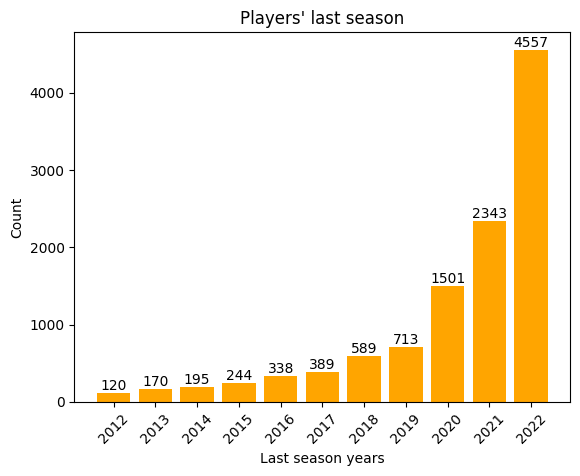

In [7]:
leagues = players["last_season"].value_counts()

fig, ax = plt.subplots()

bars = ax.bar(leagues.index, leagues.values, color="orange")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom', ha='center')

x = np.arange(2012, 2023, 1)
plt.title("Players' last season")
plt.xlabel("Last season years")
plt.ylabel("Count")
plt.xticks(x, rotation=45)
plt.show()

### Calculating mean on the Age of players playing in the leagues with most players 

In [8]:
players_groupby_league = players.groupby("league_name").size()

top_10_leagues_with_most_players = players_groupby_league.sort_values(ascending=False).head(5).index

mean_age_by_league = {}

for league in top_10_leagues_with_most_players:
    mean_age = players[players["league_name"] == league]["age"].mean().round(1)
    mean_age_by_league[league] = mean_age
    
# for league, mean_age in mean_age_by_league.items():
#     print(f"League: {league}, Average age: {mean_age}")
    
print(f"{'League':<30} {' Average age':>22}")
print("-" * 53)
for league, mean_age in mean_age_by_league.items():
    print(f"{league:<30} {mean_age:>20.1f}")

League                                    Average age
-----------------------------------------------------
Turkish Süper Lig                              26.6
Italian Serie A                                26.0
Spain Primera Division                         25.8
English Premier League                         25.0
Portuguese Liga ZON SAGRES                     24.9


### Average market value in top 5 leagues with most players

In [9]:
players_groupby_league = players.groupby("league_name").size()

top_10_leagues_with_most_players = players_groupby_league.sort_values(ascending=False).head(5).index

mean_value_by_league = {}

for league in top_10_leagues_with_most_players:
    mean_value = players[players["league_name"] == league]["market_value_in_eur"].mean().round(1)
    mean_value_by_league[league] = mean_value
    
# for league, mean_value in mean_value_by_league.items():
#     print(f"League: {league}, Average Market Value (EUR): {mean_value}")
    
print(f"{'League':<30} {'Average Market Value (EUR)':>20}")
print("-" * 58)
for league, mean_value in mean_value_by_league.items():
    print(f"{league:<30} {mean_value:>25}" )

League                         Average Market Value (EUR)
----------------------------------------------------------
Turkish Süper Lig                              1291961.9
Italian Serie A                                6685962.1
Spain Primera Division                         6892268.4
English Premier League                        13532166.4
Portuguese Liga ZON SAGRES                     2718170.5


In [10]:
players['passing'].unique

print(players.isna().sum().to_string())

player_id                                   0
first_name                                626
last_name                                   0
FIFA_long_name                              0
last_season                                 0
country_of_birth                          285
city_of_birth                             284
country_of_citizenship                      0
date_of_birth                               0
sub_position                                9
position                                    0
foot                                      247
height_in_cm                              150
market_value_in_eur                       928
highest_market_value_in_eur                46
contract_expiration_date                 1528
current_club_domestic_competition_id        0
current_club_name                        2372
fifa_id                                     0
short_name                                  0
long_name                                   0
player_positions                  

In [11]:
## with standardization

import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# define columns for the model
feature_columns = [
    'age', 'potential', 'skill_moves', 'pace', 'shooting', 'passing', 
    'dribbling', 'defending', 'physic', 'skill_dribbling', 'skill_curve', 
    'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 
    'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 
    'movement_reactions', 'movement_balance', 'power_shot_power', 
    'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 
    'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 
    'mentality_vision', 'mentality_penalties', 'mentality_composure'
]

# extract features and target variable
X_2022 = players[feature_columns]
y_2022 = players['value_eur']

# handling missing values //// filling missing values in these feature columns by replacing them with the median of each column
numerical_features = [col for col in feature_columns if col not in ['position']]
X_2022[numerical_features] = X_2022[numerical_features].fillna(X_2022[numerical_features].median())
y_2022.fillna(y_2022.median(), inplace=True)

# preprocessing, standardization
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_features)])

# shared_alpha_values = [0.001, 0.01, 0.1, 1, 10]

# lasso regression
lasso_pipeline = Pipeline([('preprocessor', preprocessor), ('lasso', Lasso())])
lasso_param_grid = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 500]}
lasso_grid_search = GridSearchCV(lasso_pipeline, lasso_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
lasso_grid_search.fit(X_2022, y_2022)
lasso_best_model = lasso_grid_search.best_estimator_
lasso_predicted_values_2023 = np.maximum(lasso_best_model.predict(X_2022), 0).round(1)
lasso_cv_r2_scores = cross_val_score(lasso_pipeline, X_2022, y_2022, cv=5, scoring='r2')

# ridge regression
ridge_pipeline = Pipeline([('preprocessor', preprocessor), ('ridge', Ridge())])
ridge_param_grid = {'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100]}
ridge_grid_search = GridSearchCV(ridge_pipeline, ridge_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
ridge_grid_search.fit(X_2022, y_2022)
ridge_best_model = ridge_grid_search.best_estimator_
ridge_predicted_values_2023 = np.maximum(ridge_best_model.predict(X_2022), 0).round(1)
ridge_cv_r2_scores = cross_val_score(ridge_pipeline, X_2022, y_2022, cv=5, scoring='r2')    

# random forest
rf_model = RandomForestRegressor(n_estimators=150, max_depth=10, min_samples_split=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_2022, y_2022, test_size=0.2, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test).round(1)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
rf_train_predictions = rf_model.predict(X_train)
rf_train_r2 = r2_score(y_train, rf_model.predict(X_train))
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_predictions))
rf_train_mae = mean_absolute_error(y_train, rf_train_predictions)
rf_train_r2 = r2_score(y_train, rf_train_predictions)

print("----------------------------------------------------")
print("Random Forest Metrics on Training Data:")
print(f"RMSE: {rf_train_rmse:.2f}, MAE: {rf_train_mae:.2f}, R-squared: {rf_train_r2:.2f}")
print("Random Forest Test Metrics on Test Data:\nRMSE: {:.2f}, MAE: {:.2f}, R-squared: {:.2f}".format(rf_rmse, rf_mae, rf_r2))
print("----------------------------------------------------")
print("Lasso Regression Metrics:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_2022, lasso_predicted_values_2023))}, MAE: {mean_absolute_error(y_2022, lasso_predicted_values_2023)}, R-squared: {r2_score(y_2022, lasso_predicted_values_2023)}")
print("Ridge Regression Metrics:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_2022, ridge_predicted_values_2023))}, MAE: {mean_absolute_error(y_2022, ridge_predicted_values_2023)}, R-squared: {r2_score(y_2022, ridge_predicted_values_2023)}")
print("----------------------------------------------------")
print("Lasso Cross-Validated R^2 Scores:", lasso_cv_r2_scores)
print("Ridge Cross-Validated R^2 Scores:", ridge_cv_r2_scores)
print("----------------------------------------------------")

predicted_df_2023 = pd.DataFrame({
    'player_id': players['player_id'],
    'value_eur': y_2022,
    'lasso_predicted_value_eur': lasso_predicted_values_2023,
    'ridge_predicted_value_eur': ridge_predicted_values_2023,
    'rf_predicted_value_eur': rf_model.predict(X_2022).round(1)
})
predicted_df_2023.to_csv('predicted_market_values_2023.csv', index=False)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------------------------------------------------
Random Forest Metrics on Training Data:
RMSE: 1083330.20, MAE: 426040.95, R-squared: 0.99
Random Forest Test Metrics on Test Data:
RMSE: 2961714.66, MAE: 708605.35, R-squared: 0.89
----------------------------------------------------
Lasso Regression Metrics:
RMSE: 6852121.082055955, MAE: 3185443.215512142, R-squared: 0.4941799047177765
Ridge Regression Metrics:
RMSE: 6859657.881978921, MAE: 3181857.3094632137, R-squared: 0.49306656728348286
----------------------------------------------------
Lasso Cross-Validated R^2 Scores: [0.42537758 0.45711719 0.42011655 0.43304478 0.43969536]
Ridge Cross-Validated R^2 Scores: [0.42539735 0.45710723 0.42011009 0.4330674  0.43970664]
----------------------------------------------------


In [12]:
## without standardization

import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# define columns for the model
feature_columns = [
    'age', 'potential', 'skill_moves', 'pace', 'shooting', 'passing', 
    'dribbling', 'defending', 'physic', 'skill_dribbling', 'skill_curve', 
    'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 
    'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 
    'movement_reactions', 'movement_balance', 'power_shot_power', 
    'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 
    'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 
    'mentality_vision', 'mentality_penalties', 'mentality_composure'
]

# extract features and target variable
X_2022 = players[feature_columns]
y_2022 = players['value_eur']

# handling missing values
numerical_features = [col for col in feature_columns if col not in ['position']]
X_2022[numerical_features] = X_2022[numerical_features].fillna(X_2022[numerical_features].median())
y_2022.fillna(y_2022.median(), inplace=True)

# preprocessing
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_features)])

# shared_alpha_values = [0.001, 0.01, 0.1, 1, 10]

# lasso regression
lasso_pipeline = Pipeline([('lasso', Lasso())])
lasso_param_grid = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 500]}
lasso_grid_search = GridSearchCV(lasso_pipeline, lasso_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
lasso_grid_search.fit(X_2022, y_2022)
lasso_best_model = lasso_grid_search.best_estimator_
lasso_predicted_values_2023 = np.maximum(lasso_best_model.predict(X_2022), 0).round(1)
lasso_cv_r2_scores = cross_val_score(lasso_pipeline, X_2022, y_2022, cv=5, scoring='r2')

# ridge regression
ridge_pipeline = Pipeline([('ridge', Ridge())])
ridge_param_grid = {'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100]}
ridge_grid_search = GridSearchCV(ridge_pipeline, ridge_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
ridge_grid_search.fit(X_2022, y_2022)
ridge_best_model = ridge_grid_search.best_estimator_
ridge_predicted_values_2023 = np.maximum(ridge_best_model.predict(X_2022), 0).round(1)
ridge_cv_r2_scores = cross_val_score(ridge_pipeline, X_2022, y_2022, cv=5, scoring='r2')    

# random forest
rf_model = RandomForestRegressor(n_estimators=150, max_depth=10, min_samples_split=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_2022, y_2022, test_size=0.2, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test).round(1)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
rf_train_predictions = rf_model.predict(X_train)
rf_train_r2 = r2_score(y_train, rf_model.predict(X_train))
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_predictions))
rf_train_mae = mean_absolute_error(y_train, rf_train_predictions)
rf_train_r2 = r2_score(y_train, rf_train_predictions)

print("----------------------------------------------------")
print("Random Forest Metrics on Training Data:")
print(f"RMSE: {rf_train_rmse:.2f}, MAE: {rf_train_mae:.2f}, R-squared: {rf_train_r2:.2f}")
print("Random Forest Test Metrics on Test Data:\nRMSE: {:.2f}, MAE: {:.2f}, R-squared: {:.2f}".format(rf_rmse, rf_mae, rf_r2))
print("----------------------------------------------------")
print("Lasso Regression Metrics:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_2022, lasso_predicted_values_2023))}, MAE: {mean_absolute_error(y_2022, lasso_predicted_values_2023)}, R-squared: {r2_score(y_2022, lasso_predicted_values_2023)}")
print("Ridge Regression Metrics:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_2022, ridge_predicted_values_2023))}, MAE: {mean_absolute_error(y_2022, ridge_predicted_values_2023)}, R-squared: {r2_score(y_2022, ridge_predicted_values_2023)}")
print("----------------------------------------------------")
print("Lasso Cross-Validated R^2 Scores:", lasso_cv_r2_scores)
print("Ridge Cross-Validated R^2 Scores:", ridge_cv_r2_scores)
print("----------------------------------------------------")

# predicted_df_2023 = pd.DataFrame({
#     'player_id': players['player_id'],
#     'value_eur': y_2022,
#     'lasso_predicted_value_eur': lasso_predicted_values_2023,
#     'ridge_predicted_value_eur': ridge_predicted_values_2023,
#     'rf_predicted_value_eur': rf_model.predict(X_2022).round(1)
# })
# predicted_df_2023.to_csv('predicted_market_values_2023.csv', index=False)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------------------------------------------------
Random Forest Metrics on Training Data:
RMSE: 1083330.20, MAE: 426040.95, R-squared: 0.99
Random Forest Test Metrics on Test Data:
RMSE: 2961714.66, MAE: 708605.35, R-squared: 0.89
----------------------------------------------------
Lasso Regression Metrics:
RMSE: 6851884.112307492, MAE: 3185604.36282821, R-squared: 0.49421489008556474
Ridge Regression Metrics:
RMSE: 6851958.373966777, MAE: 3185604.8196522985, R-squared: 0.4942039264894411
----------------------------------------------------
Lasso Cross-Validated R^2 Scores: [0.42537745 0.45711721 0.42011653 0.43304465 0.43969522]
Ridge Cross-Validated R^2 Scores: [0.42537741 0.45711865 0.4201162  0.4330445  0.43969503]
----------------------------------------------------


In [13]:
# Calculate the differences for each prediction model
predicted_df_2023['lasso_diff'] = predicted_df_2023['lasso_predicted_value_eur'] - predicted_df_2023['value_eur']
predicted_df_2023['ridge_diff'] = predicted_df_2023['ridge_predicted_value_eur'] - predicted_df_2023['value_eur']
predicted_df_2023['rf_diff'] = predicted_df_2023['rf_predicted_value_eur'] - predicted_df_2023['value_eur']

def display_largest_change(df, column, model_name):
    largest_increase = df.sort_values(by=column, ascending=False).head(1)
    largest_decrease = df.sort_values(by=column, ascending=True).head(1)

    print(f"{model_name} - Largest Market Value Change\n")
    print(f"{'Player ID':<15} | {'Actual Value (€)':<20} | {'Predicted Change (€)':<20} | Change Type")
    print("-" * 75)

    # Display the largest increase
    increase_info = largest_increase.iloc[0]
    print(f"{int(increase_info['player_id']):<15} | {increase_info['value_eur']:20,.2f} | {increase_info[column]:20,.2f} | Increase")

    # Display the largest decrease
    decrease_info = largest_decrease.iloc[0]
    print(f"{int(decrease_info['player_id']):<15} | {decrease_info['value_eur']:20,.2f} | {decrease_info[column]:20,.2f} | Decrease")
    print("\n")

# Display the largest increase and decrease for each model
display_largest_change(predicted_df_2023, 'lasso_diff', 'Lasso')
display_largest_change(predicted_df_2023, 'ridge_diff', 'Ridge')
display_largest_change(predicted_df_2023, 'rf_diff', 'Random Forest')

Lasso - Largest Market Value Change

Player ID       | Actual Value (€)     | Predicted Change (€) | Change Type
---------------------------------------------------------------------------
42710           |         1,400,000.00 |        16,504,405.10 | Increase
342229          |       194,000,000.00 |      -161,145,123.20 | Decrease


Ridge - Largest Market Value Change

Player ID       | Actual Value (€)     | Predicted Change (€) | Change Type
---------------------------------------------------------------------------
42710           |         1,400,000.00 |        16,398,257.80 | Increase
342229          |       194,000,000.00 |      -161,313,995.30 | Decrease


Random Forest - Largest Market Value Change

Player ID       | Actual Value (€)     | Predicted Change (€) | Change Type
---------------------------------------------------------------------------
17259           |        13,500,000.00 |        66,159,690.60 | Increase
342229          |       194,000,000.00 |       -86,723,7

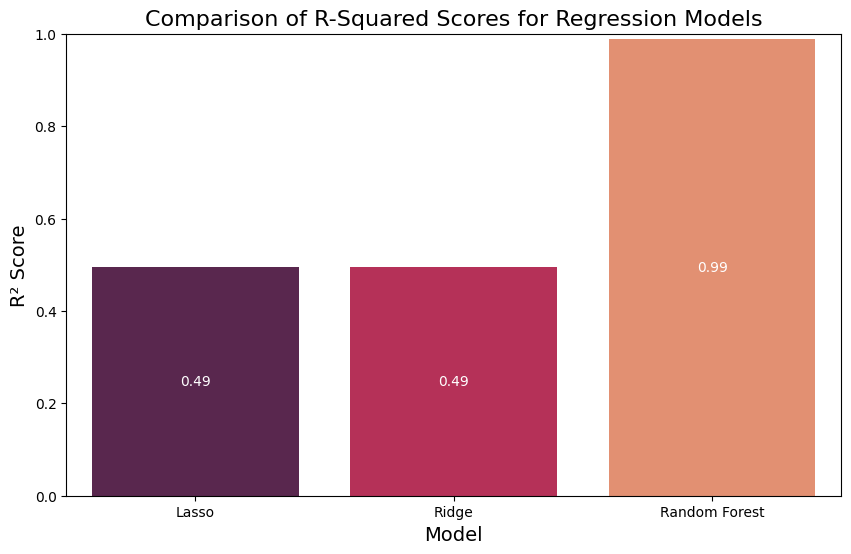

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# lasso_r2 = np.mean(lasso_cv_r2_scores)
# ridge_r2 = np.mean(ridge_cv_r2_scores)
rf_r2 = rf_train_r2  # using the training R-squared for Random Forest

lasso_r2 = r2_score(y_2022, lasso_predicted_values_2023)
ridge_r2 = r2_score(y_2022, ridge_predicted_values_2023)

# data for plotting
model_scores = {
    'Model': ['Lasso', 'Ridge', 'Random Forest'],
    'R-Squared Score': [lasso_r2, ridge_r2, rf_r2]
}

df_scores = pd.DataFrame(model_scores)

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Model', y='R-Squared Score', data=df_scores, palette='rocket')

for p in barplot.patches:
    height = p.get_height()
    barplot.text(p.get_x() + p.get_width() / 2., 
                 height / 2, 
                 f'{height:.2f}', 
                 ha='center', 
                 va='center', 
                 color='white')

plt.title('Comparison of R-Squared Scores for Regression Models', fontsize=16)
plt.ylabel('R² Score', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.ylim(0, 1)
plt.show()

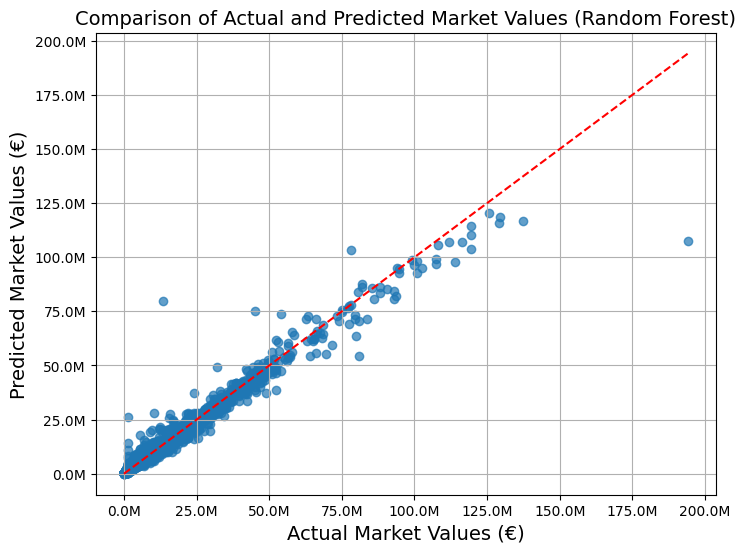

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

predicted_df_2023 = pd.read_csv('predicted_market_values_2023.csv')

actual_values = predicted_df_2023['value_eur']
predicted_values_rf = predicted_df_2023['rf_predicted_value_eur']

plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values_rf, alpha=0.7)
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], 'r--')
plt.title('Comparison of Actual and Predicted Market Values (Random Forest)', fontsize=14)
plt.xlabel('Actual Market Values (€)', fontsize=14)
plt.ylabel('Predicted Market Values (€)', fontsize=14)
formatter = mticker.FuncFormatter(lambda x, pos: f'{x/1e6}M')
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.show()

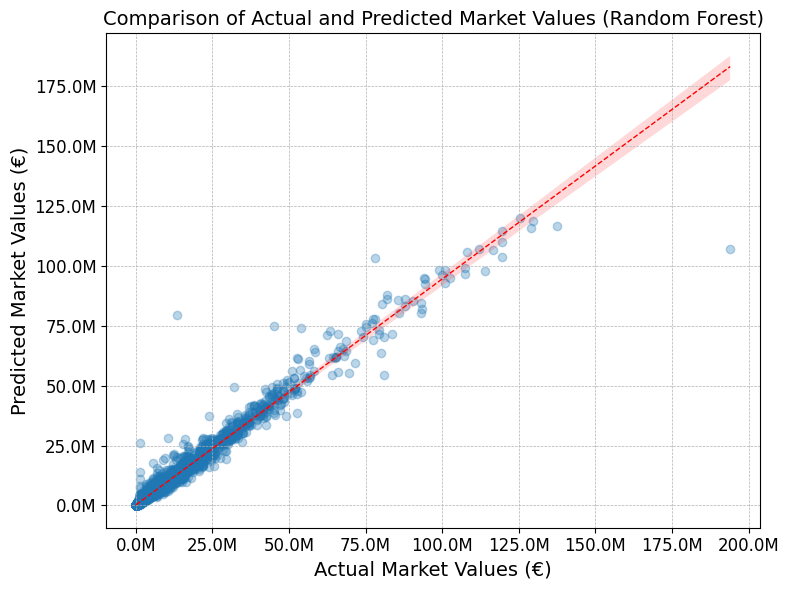

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import pandas as pd

predicted_df_2023 = pd.read_csv('predicted_market_values_2023.csv')

plt.figure(figsize=(8, 6))
sns.regplot(x='value_eur', y='rf_predicted_value_eur', data=predicted_df_2023, scatter_kws={'alpha':0.3}, line_kws={'color': 'red', 'lw': 1, 'ls': '--'})

plt.title('Comparison of Actual and Predicted Market Values (Random Forest)', fontsize=14)
plt.xlabel('Actual Market Values (€)', fontsize=14)
plt.ylabel('Predicted Market Values (€)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', ls='--', lw=0.5)
formatter = mticker.FuncFormatter(lambda x, pos: f'{x/1e6}M')
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()

plt.show()

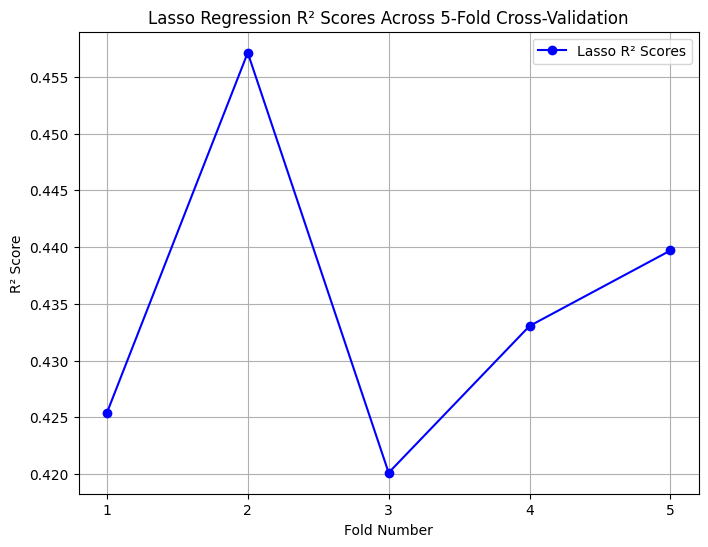

In [17]:
# line plot for lasso regression R² scores across 5-Fold cross-validation

lasso_cv_r2_scores = cross_val_score(lasso_pipeline, X_2022, y_2022, cv=5, scoring='r2')
plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), lasso_cv_r2_scores, marker='o', color='b', label='Lasso R² Scores')
plt.title('Lasso Regression R² Scores Across 5-Fold Cross-Validation')
plt.xlabel('Fold Number')
plt.ylabel('R² Score')
plt.xticks(range(1, 6))
plt.grid(True)
plt.legend()
plt.show()

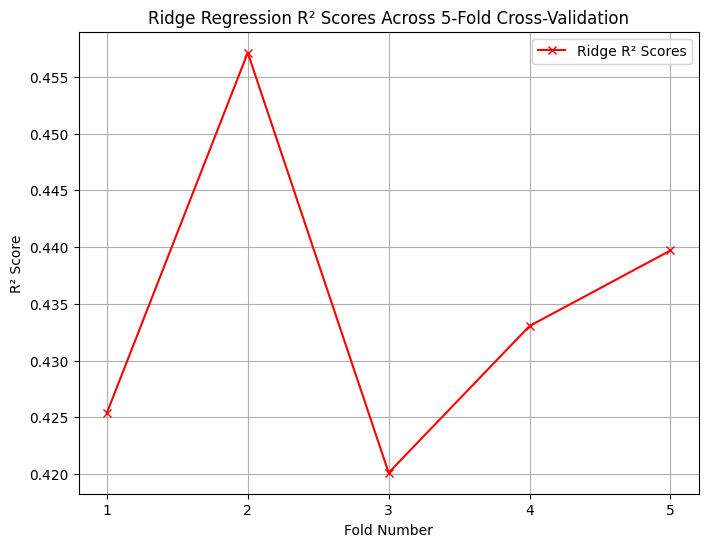

In [18]:
# line plot for ridge regression R² scores across 5-Fold cross-validation

ridge_cv_r2_scores = cross_val_score(ridge_pipeline, X_2022, y_2022, cv=5, scoring='r2')
plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), ridge_cv_r2_scores, marker='x', color='r', label='Ridge R² Scores')
plt.title('Ridge Regression R² Scores Across 5-Fold Cross-Validation')
plt.xlabel('Fold Number')
plt.ylabel('R² Score')
plt.xticks(range(1, 6))
plt.grid(True)
plt.legend()
plt.show()

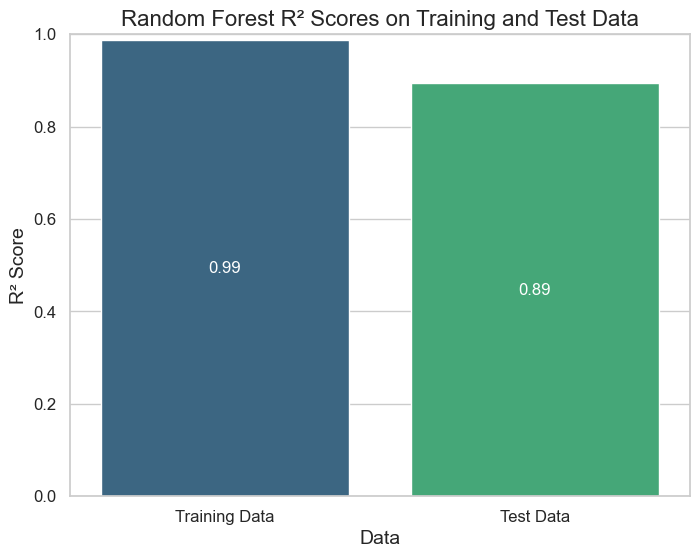

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

rf_train_r2 = r2_score(y_train, rf_model.predict(X_train))
rf_test_r2 = r2_score(y_test, rf_predictions)

rf_r2_scores = {
    "Data": ["Training Data", "Test Data"],
    "R² Score": [rf_train_r2, rf_test_r2]
}

rf_r2_df = pd.DataFrame(rf_r2_scores)

sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
barplot = sns.barplot(x="Data", y="R² Score", data=rf_r2_df, palette="viridis")

for p in barplot.patches:
    height = p.get_height()
    barplot.text(p.get_x() + p.get_width() / 2., 
                 height / 2, 
                 f'{height:.2f}', 
                 ha='center', 
                 va='center', 
                 color='white')
    
plt.title('Random Forest R² Scores on Training and Test Data', fontsize=16)
plt.ylabel('R² Score', fontsize=14)
plt.xlabel('Data', fontsize=14)
plt.ylim(0, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

<module 'matplotlib.pyplot' from 'c:\\Users\\Veronii\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

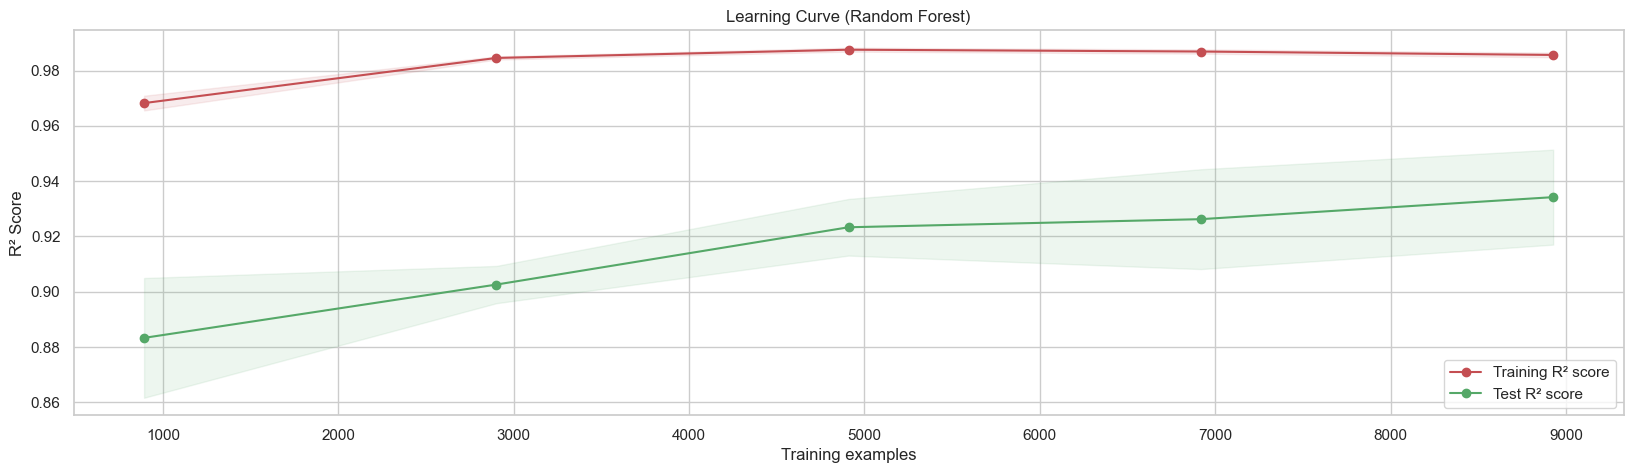

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("R² Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.grid(True)
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training R² score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test R² score")
    axes.legend(loc="lower right")

    return plt

rf_model = RandomForestRegressor(n_estimators=150, max_depth=10, min_samples_split=5, random_state=42)
plot_learning_curve(rf_model, "Learning Curve (Random Forest)", X_2022, y_2022, cv=5)